# Unsupervised concept drift detectors: SyncStream & SCD



In [1]:
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder

import numpy as np
import math
from sklearn.decomposition import PCA
from scipy.stats import rankdata, norm, gaussian_kde
from sklearn.utils import resample
from statistics import variance

import matplotlib.pyplot as plt
from time import time

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import sklearn
import category_encoders
import scipy

print(sklearn.__version__)
print(category_encoders.__version__)
print(scipy.__version__)

1.0.2
2.5.1.post0
1.9.1


### Reading the SEA dataset

In [2]:
def read_sea(filename):
    data, meta = arff.loadarff(filename)
    df = pd.DataFrame(data)
#     df = df.iloc[54450:55450,:] # For testing SCD with miniature scale
    
    X = df[["attrib1", "attrib2", "attrib3"]]
    
    X_train, X_test = train_test_split(X, train_size=0.30, shuffle=False)
    
    return X_train, X_test

### Reading the AGRAW dataset

In [3]:
def read_agraw(filename):
    data, meta = arff.loadarff(filename)
    df = pd.DataFrame(data)

    le = LabelEncoder()
#     te = TargetEncoder(cols=["elevel", "car", "zipcode"], smoothing=0, return_df=False)
#     ohe = OneHotEncoder()
#     oe = OrdinalEncoder()

    X = df.drop(columns=["class"])
    y = le.fit_transform(df["class"].str.decode("utf-8"))

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.30, shuffle=False)

#     encoder = 'target'
    
#     if encoder == 'onehot':
#         # OneHotEncoder
#         X_train_num = X_train.drop(columns=["elevel", "car", "zipcode"])
#         X_train_cat = X_train[["elevel", "car", "zipcode"]]
#         X_train_cat = ohe.fit_transform(X_train_cat).toarray()
#         X_train = np.concatenate([X_train_num, X_train_cat], axis=1)
#         X_test_num = X_test.drop(columns=["elevel", "car", "zipcode"])
#         X_test_cat = X_test[["elevel", "car", "zipcode"]]
#         X_test_cat = ohe.transform(X_test_cat).toarray()
#         X_test = np.concatenate([X_test_num, X_test_cat], axis=1)
#     elif encoder == 'ordinal':
#         # OrdinalEncoder
#         X_train_num = X_train.drop(columns=["elevel", "car", "zipcode"])
#         X_train_cat = X_train[["elevel", "car", "zipcode"]]
#         X_train_cat = oe.fit_transform(X_train_cat)
#         X_train = np.concatenate([X_train_num, X_train_cat], axis=1)
#         X_test_num = X_test.drop(columns=["elevel", "car", "zipcode"])
#         X_test_cat = X_test[["elevel", "car", "zipcode"]]
#         X_test_cat = oe.transform(X_test_cat)
#         X_test = np.concatenate([X_test_num, X_test_cat], axis=1)
#     elif encoder == 'target':
#         # TargetEncoder
#         X_train = te.fit_transform(X_train, y_train)
#         X_test = te.transform(X_test)
    
    return X_train, X_test, y_train, y_test

### Preprocessing

In [4]:
# def preprocess(X_train, X_test, total_batches):
#     scaler = MinMaxScaler()

#     X_train = pd.DataFrame(scaler.fit_transform(X_train))
#     X_test = pd.DataFrame(scaler.transform(X_test))

#     X_test_batches = np.array_split(X_test, total_batches)

#     return X_train, X_test_batches

def ensure_df(data):
    checked_data = data
    if not isinstance(data, pd.DataFrame):
        checked_data = pd.DataFrame(data)
    return checked_data

def encode(ref_data, test_batches, ref_labels, encoder=None):
    encoded_ref_data = ref_data
    encoded_test_batches = test_batches
    
    if encoder == 'onehot':
        # OneHotEncoder
        ohe = OneHotEncoder()
        ref_data_num = ref_data.select_dtypes(include=[np.number])
        ref_data_cat = ref_data.select_dtypes(exclude=[np.number])
        encoded_ref_data_cat = ohe.fit_transform(ref_data_cat).toarray()
        encoded_ref_data = pd.DataFrame(np.concatenate([ref_data_num, encoded_ref_data_cat], axis=1))
        encoded_test_batches = []
        for batch in range(len(test_batches)):
            test_data_num = test_batches[batch].select_dtypes(include=[np.number])
            test_data_cat = test_batches[batch].select_dtypes(exclude=[np.number])
            encoded_test_data_cat = ohe.transform(test_data_cat).toarray()
            encoded_test_batches.append(pd.DataFrame(np.concatenate([test_data_num, encoded_test_data_cat], axis=1)))
    elif encoder == 'ordinal':
        # OrdinalEncoder
        oe = OrdinalEncoder()
        ref_data_num = ref_data.select_dtypes(include=[np.number])
        ref_data_cat = ref_data.select_dtypes(exclude=[np.number])
        encoded_ref_data_cat = oe.fit_transform(ref_data_cat)
        encoded_ref_data = pd.DataFrame(np.concatenate([ref_data_num, encoded_ref_data_cat], axis=1))
        encoded_test_batches = []
        for batch in range(len(test_batches)):
            test_data_num = test_batches[batch].select_dtypes(include=[np.number])
            test_data_cat = test_batches[batch].select_dtypes(exclude=[np.number])
            encoded_test_data_cat = oe.transform(test_data_cat)
            encoded_test_batches.append(pd.DataFrame(np.concatenate([test_data_num, encoded_test_data_cat], axis=1)))
    elif encoder == 'target' and ref_labels is not None:
        # TargetEncoder
        cols = ref_data.select_dtypes(exclude=[np.number]).columns
        te = TargetEncoder(cols, smoothing=0, return_df=True)
        encoded_ref_data = te.fit_transform(ref_data, ref_labels)
        encoded_test_batches = []
        for batch in range(len(test_batches)):
            encoded_test_batches.append(te.transform(test_batches[batch]))
        
    return encoded_ref_data, encoded_test_batches
    
def scale(ref_data, test_batches, scaler=None):
    scaled_ref_data = ref_data
    scaled_test_batches = test_batches
    
    if scaler == 'minmax':
        mms = MinMaxScaler()
        scaled_ref_data = pd.DataFrame(mms.fit_transform(ref_data))
        scaled_test_batches = list(map(lambda batch: pd.DataFrame(mms.transform(batch)), test_batches))
        
    return scaled_ref_data, scaled_test_batches

### Postprocessing

In [5]:
def postprocess(real_drift, detected_drifts, total_batches):
    if len(detected_drifts) <= 0:
        return 0.0, 1.0
    else:
        false_positives = list(filter(lambda flagged_batch: flagged_batch < real_drift, detected_drifts))
        false_positive_rate = len(false_positives) / (real_drift - 1)
        if false_positive_rate < 0:
            false_positive_rate = 0.0
            
        first_detected_drift = detected_drifts[0]
        for i in range(len(detected_drifts)):
            if detected_drifts[i] >= real_drift:
                first_detected_drift = detected_drifts[i]
                break
        latency = (first_detected_drift - real_drift) / (total_batches - real_drift)
        if latency < 0:
            latency = 1.0
            
        return false_positive_rate, latency
    
def postprocess_rw(real_drifts, detected_drifts, n_batches):
    if len(detected_drifts) <= 0:
        return 0.0, 0.0
    else:
        false_positives = list(filter(lambda detected_drift: detected_drift not in real_drifts, detected_drifts))
        correct_positives = list(filter(lambda real_drift: real_drift in detected_drifts, real_drifts))

        false_positive_rate = len(false_positives) / (n_batches - len(real_drifts))
        accuracy = len(correct_positives) / len(real_drifts)
        
        return false_positive_rate, accuracy
    
    
def graph(deltas, crits, y_label, deltas_reverse=None, crits_reverse=None):
    print(deltas)
    print(crits)
    print(y_label)
    print(deltas_reverse)
    print(crits_reverse)
    
    plt.ylabel(y_label)
    plt.xlabel("Test batch")
    x_range = np.arange(1, len(deltas) + 1)
    
    bar_width = 0.5
    offset = 0
    if deltas_reverse:
        bar_width = 0.25
        offset = 0.125
    
    plt.bar(x_range - offset, deltas, width=bar_width, color="b")
    plt.plot(x_range - offset, crits, "r-")
    if deltas_reverse:
        plt.bar(x_range + offset, deltas_reverse, width=bar_width, color="c")
        plt.plot(x_range + offset, crits_reverse, "m-")
        
    plt.show()

### SyncStream-PCA

In [6]:
def syncstream_pca_all(raw_ref_data, raw_test_batches, ref_labels=None, encoder=None, scaler=None, consecutive=False):
    
    # Make sure data is in DataFrames
    ref_data = ensure_df(raw_ref_data)
    test_batches = []
    for batch in range(len(raw_test_batches)):
        test_batches.append(ensure_df(raw_test_batches[batch]))
    
    # Encode and scale the data
    if encoder:
        ref_data, test_batches = encode(ref_data, test_batches, ref_labels, encoder)
    if scaler:
        ref_data, test_batches = scale(ref_data, test_batches, scaler)
        
    print(test_batches[0].head())

    deltas = []
    crits = []
    drifts = []

    pca = PCA(n_components=1)

    pca.fit(ref_data.values)
    ref_eigenvector = pca.components_[0]

    for batch in range(len(test_batches)):
        pca.fit(test_batches[batch].values)
        batch_eigenvector = pca.components_[0]
        measured_angle = np.degrees(np.arccos(np.dot(batch_eigenvector, ref_eigenvector)))
        crit = 30
        
        if (consecutive):
            ref_eigenvector = batch_eigenvector
        
        deltas.append(measured_angle)
        crits.append(crit)
        if (measured_angle > crit):
            drifts.append(batch + 1)
    
    y_label = "SyncStream-PCA"
    if consecutive:
        y_label += " (consecutive)"
    else:
        y_label += " (fixed reference)"
    graph(deltas, crits, y_label)

    return drifts
    
def syncstream_pca(ref_data, test_data, ref_labels=None, encoder=None, scaler=None):
    drifts = syncstream_pca_all(ref_data, [test_data], ref_labels, encoder, scaler)
    return len(drifts) == 1
    

### SyncStream-Stat

In [7]:
def midrank(Dt, ranks_in_union, start_i, j):
    rank_sum = 0
    for i in range(start_i, start_i + len(Dt)):
        rank_sum += ranks_in_union[i]
    return rank_sum / len(Dt)

def v2(Dt, u, start_i):
    rank_diff_sum = 0
    for j in range(Dt.shape[1]):
        ranks_in_union = rankdata(u[:, j])
        ranks_in_Dt = rankdata(Dt[:, j])
        midrank_j = midrank(Dt, ranks_in_union, start_i, j)
        for i in range(0, len(Dt)):
            rank_diff_sum += (ranks_in_union[start_i + i] - ranks_in_Dt[i] - midrank_j + (len(Dt) + 1) / 2) ** 2
    return (1 / (len(Dt) - 1)) * rank_diff_sum

def midrank_diff(Dt, Dt1, u, j):
    ranks_in_union = rankdata(u[:, j])
    return midrank(Dt, ranks_in_union, 0, j) - midrank(Dt1, ranks_in_union, len(Dt), j)

def wilcoxon_test(Dt, Dt1, p):
    u = np.concatenate((Dt, Dt1))
    v2_Dt = v2(Dt, u, 0)
    v2_Dt1 = v2(Dt1, u, len(Dt))
    var_BF = (len(Dt) + len(Dt1)) * v2_Dt / len(Dt1) + (len(Dt) + len(Dt1)) * v2_Dt1 / len(Dt)
    sd_BF = np.sqrt(var_BF)
    midrank_diff_sum = 0
    for j in range(Dt.shape[1]):
        midrank_diff_sum += midrank_diff(Dt, Dt1, u, j)
    WBF = np.sqrt(len(Dt) * len(Dt1) / (len(Dt) + len(Dt1))) * midrank_diff_sum / sd_BF
    crit = norm.ppf(1-p/2)
    return abs(WBF) > crit, abs(WBF), crit

def syncstream_stat_all(raw_ref_data, raw_test_batches, ref_labels=None, encoder=None, scaler=None, p=0.01, consecutive=False):
    
    # Make sure data is in DataFrames
    ref_data = ensure_df(raw_ref_data)
    test_batches = []
    for batch in range(len(raw_test_batches)):
        test_batches.append(ensure_df(raw_test_batches[batch]))
    
    # Encode and scale the data
    if encoder:
        ref_data, test_batches = encode(ref_data, test_batches, ref_labels, encoder)
    if scaler:
        ref_data, test_batches = scale(ref_data, test_batches, scaler)
    
    print(test_batches[0].head())
    
    deltas = []
    crits = []
    drifts = []

    for batch in range(len(test_batches)):
        ref_batch = ref_data
        if consecutive and batch != 0:
            ref_batch = test_batches[batch - 1]
        detected_stat, delta, crit = wilcoxon_test(ref_batch.values, test_batches[batch].values, p)
        deltas.append(delta)
        crits.append(crit)
        if (detected_stat):
            drifts.append(batch + 1)
    
    y_label = "SyncStream-Stat"
    if consecutive:
        y_label += " (consecutive)"
    else:
        y_label += " (fixed reference)"
    graph(deltas, crits, y_label)
    
    return drifts

def syncstream_stat(ref_data, test_data, ref_labels=None, encoder=None, scaler=None, p=0.01):
    drifts = syncstream_stat_all(ref_data, [test_data], ref_labels, encoder, scaler, p)
    return len(drifts) == 1

### SCD

In [8]:
# Gaussian kernel function

# def g_kernel(bandwidth, diff):
#     k = len(diff)
#     det = np.linalg.det(bandwidth)
#     inv = np.linalg.inv(bandwidth)
#     exponent_matrix = np.matmul(np.matmul(diff.T, inv), diff)
#     return (1 / (np.sqrt(2 * np.pi)**k * np.sqrt(det))) * np.exp((-1 / 2) * exponent_matrix)


# Learning bandwidths with Expectation Maximization

# def init_bandwidths(n, k):
#     print('n', n)
#     print('k', k)
#     bandwidths = []
#     for i in range(n):
#         bandwidths.append(np.identity(k))
#     return bandwidths

# def soft_membership(bandwidth, S1, i, j):
#     if i == j:
#         return 0
#     density_sum = 0
#     for t in range(len(S1)):
#         if t != j:
#             density_sum += g_kernel(bandwidth, S1[j] - S1[t])
#     return g_kernel(bandwidth, S1[j] - S1[i]) / density_sum

# def bandwidth_update(i, S1, bandwidths):
#     nominator_sum = np.zeros((len(S1[0]), len(S1[0])))
#     denominator_sum = 0
#     for j in range(len(S1)):
#         soft_mb = soft_membership(bandwidths[i], S1, i, j)
#         point_kernel_diff = S1[j] - S1[i]
#         nominator_sum += soft_mb * np.outer(point_kernel_diff, point_kernel_diff.T)
#         denominator_sum += soft_mb
#     return nominator_sum / denominator_sum

# def pseudo_LLH(S1, bandwidths):
#     LLH = 0
#     for j in range(len(S1)):
#         temp_sum = 0
#         for i in range(len(S1)):
#             if i != j:
#                 temp_sum += (1 / (len(S1) - 1)) * g_kernel(bandwidths[i], S1[j] - S1[i])
#         LLH += np.log(temp_sum)
#     return LLH

# def learn_bandwidths(S1, maxIteration, phi):
#     bandwidths = init_bandwidths(len(S1), len(S1[0]))
#     L = []
#     for t in range(maxIteration):
#         # compute density for all i, j
#         # compute soft membership for all i, j
#         # compute new bandwidth for all i
#         for i in range(len(bandwidths)):
#             bandwidths[i] = bandwidth_update(i, S1, bandwidths)
#         # compute L and check for stopping criterion
#         L.append(pseudo_LLH(S1, bandwidths))
#         print(L[t])
#         if t > 0:
#             if (((L[t] - L[t - 1]) / L[t - 1]) < phi):
#                 break
#     return bandwidths


# The test statistic

# def density_estimate(S1, bandwidths, s):
#     density = 0
#     for i in range(len(S1)):
#         density += (1 / len(S1)) * g_kernel(bandwidths[i], s - S1[i])
#     return density

# def log_likelihood(bandwidths, S1, data, kde):
#     LLH = 0
#     for y in range(len(data)):
#         LLH += np.log(density_estimate(S1, bandwidths, data[y]))
#     return LLH

def delta(S1, S2, Sprime, kde):
#     return log_likelihood(bandwidths, S1, Sprime, kde) 
#         - (len(Sprime) / len(S2)) * log_likelihood(bandwidths, S1, S2, kde)
    return np.sum(kde.logpdf(Sprime.T)) - (len(Sprime) / len(S2)) * np.sum(kde.logpdf(S2.T)) # drop-in replacement


# Determining the critical value
    
def est_var_estimates(S2, estSize, kde):
    est_time = time()
    Est = []
    std_prev_t = 0.0
    for t in range(estSize):
        R = resample(S2)
#         print("resampling done at", time() - est_var_timer, "seconds")
#         densities = map(lambda x: np.log(density_estimate(S1, bandwidths, x)), R)
        densities = kde.logpdf(R.T) # drop-in replacement
#         print("densities computed at", time() - est_var_timer, "seconds")
        Est.append((len(S2) / (len(S2) - 1)) * variance(densities))
        
        # stopping criterion after 30 estimates if their SD stabilizes within 1 percent
        std_current_t = np.std(Est)
        diff_std = float('inf')
        if t > 1:
            diff_std = abs(std_prev_t - std_current_t) / std_prev_t
        print("t", t, 
              "mean:", round(np.mean(Est), 5), 
              "std:", round(std_current_t, 5), 
              "diff_std:", round(diff_std, 5), 
              "time:", time() - est_time
             )
        if t >= 29 and diff_std < 0.01:
            break
        std_prev_t = std_current_t
        
    Est.sort()
    return Est

def critical_value(p, stepSize, S2_size, Sprime_size, kde, Est):
    M = math.floor(p / stepSize - 1)
    C = []
    for i in range(M):
        alpha = (i + 1) * stepSize
        beta = p - alpha
        # estimate variance for this beta:
        upper_limit = Est[math.ceil((len(Est) * (1 - beta) - 1))]
        var = (Sprime_size + Sprime_size**2/S2_size) * upper_limit
        # find c such that P(D <= c) = alpha, D ~ N(0, var):
        D = norm(0, np.sqrt(var))
        c = D.ppf(alpha)
        C.append(c)
    Cmax = np.amin(C)
    return Cmax


# Full procedure

def density_test(S1, S2, Sprime, p, kde, Est):
    # Calculate delta between S2 and S'
    d = delta(S1, S2, Sprime, kde)
    # Get critical value from S2
    stepSize = 0.002
    c = critical_value(p, stepSize, len(S2), len(Sprime), kde, Est)
    # Report drift if delta < critical value
    return d < c, d, c

def scd_all(raw_ref_data, raw_test_batches, ref_labels=None, encoder=None, scaler=None, p=0.08, bidirectional=False):
    
    # Make sure data is in DataFrames
    ref_data = ensure_df(raw_ref_data)
    test_batches = []
    for batch in range(len(raw_test_batches)):
        test_batches.append(ensure_df(raw_test_batches[batch]))
    
    # Encode and scale the data
    if encoder:
        ref_data, test_batches = encode(ref_data, test_batches, ref_labels, encoder)
    if scaler:
        ref_data, test_batches = scale(ref_data, test_batches, scaler)
        
    print(test_batches[0].head())
    
    # Randomly partition the training set S into S1 and S2
    S1, S2 = train_test_split(ref_data, train_size=0.50, shuffle=True)
    
    # Use EM to learn the kernel model over S1
#     bandwidths = learn_bandwidths(S1.to_numpy(), maxIteration=100, phi=0.01)
    kde = gaussian_kde(S1.to_numpy().T) # drop-in replacement
    
    # Estimate the variance
    estSize = 4000
    Est = est_var_estimates(S2.to_numpy(), estSize, kde)
    
    deltas = []
    crits = []
    deltas_reverse = []
    crits_reverse = []
    drifts = []
    
    # Consider each test batch S':
    for batch in range(len(test_batches)):
        p_value = p
        if bidirectional:
            p_value = p/2
            
        detected_scd, delta, crit = density_test(
            S1.to_numpy(), 
            S2.to_numpy(), 
            test_batches[batch].to_numpy(), 
            p_value, 
            kde, 
            Est
        )
        deltas.append(delta)
        deltas_reverse.append(0)
        crits.append(crit)
        crits_reverse.append(0)
        if detected_scd:
            drifts.append(batch + 1)
            
        # If no drift was detected, run again with S and S' reversed
        elif bidirectional:
            print("Running in reverse for batch", batch)
            S1_reverse, S2_reverse = train_test_split(test_batches[batch], train_size=0.50, shuffle=True)
            
            # Use EM to learn the kernel model over S1
        #     bandwidths = learn_bandwidths(S1.to_numpy(), maxIteration=100, phi=0.01)
            kde_reverse = gaussian_kde(S1_reverse.to_numpy().T) # drop-in replacement
            
            # Estimate the variance
            Est_reverse = est_var_estimates(S2_reverse.to_numpy(), estSize, kde_reverse)
            
            detected_scd_reverse, delta_reverse, crit_reverse = density_test(
                S1_reverse.to_numpy(), 
                S2_reverse.to_numpy(), 
                ref_data.to_numpy(), 
                p_value, 
                kde_reverse, 
                Est_reverse
            )
            deltas_reverse[batch] = delta_reverse
            crits_reverse[batch] = crit_reverse
            if detected_scd_reverse:
                drifts.append(batch + 1)
    
    y_label = "SCD"
    if bidirectional:
        y_label += " (bidirectional)"
        graph(deltas, crits, y_label, deltas_reverse, crits_reverse)
    else:
        y_label += " (unidirectional)"
        graph(deltas, crits, y_label)
    
            
    return drifts

def scd(ref_data, test_data, ref_labels=None, encoder=None, scaler=None, p=0.08, bidirectional=False):
    drifts = scd_all(ref_data, [test_data], ref_labels, encoder, scaler, p, bidirectional)
    return len(drifts) == 1

### Run synthetic datasets:

In [9]:
def run_detectors(X_train, X_test, y_train, filename, real_drift, n_batches, encoder, scaler):
    ref_data = X_train
    test_batches = np.array_split(X_test, n_batches)
    ref_labels = y_train
    
#     timer = time()
#     drifts_pca_ref = syncstream_pca_all(ref_data, test_batches, ref_labels, encoder, scaler)
#     print("syncstream_pca_all took", time() - timer, "seconds")
    
#     timer = time()
#     drifts_stat_ref = syncstream_stat_all(ref_data, test_batches, ref_labels, encoder, scaler)
#     print("syncstream_stat_all took", time() - timer, "seconds")
    
    drifts_scd_unidir = []
    if encoder != "onehot": # due to matrix errors
        timer = time()
        drifts_scd_unidir = scd_all(ref_data, test_batches, ref_labels, encoder, scaler)
        print("scd_all took", time() - timer, "seconds")
        
#     timer = time()
#     drifts_pca_orig = syncstream_pca_all(ref_data, test_batches, ref_labels, encoder, scaler, consecutive=True)
#     print("syncstream_pca_all (cons) took", time() - timer, "seconds")
    
#     timer = time()
#     drifts_stat_orig = syncstream_stat_all(ref_data, test_batches, ref_labels, encoder, scaler, consecutive=True)
#     print("syncstream_stat_all (cons) took", time() - timer, "seconds")

#     drifts_scd_bidir = []
#     if encoder != "onehot": # due to matrix errors
#         drifts_scd_bidir = scd_all(ref_data, test_batches, ref_labels, encoder, scaler, bidirectional=True)
    
    print("\n", filename, "encoder:", encoder)
    report_1 = [
#         "PCA_ref:",
#         drifts_pca_ref,
#         postprocess(real_drift, drifts_pca_ref, n_batches),
#         "Stat_ref:",
#         drifts_stat_ref,
#         postprocess(real_drift, drifts_stat_ref, n_batches),
        "SCD_unidir:",
        drifts_scd_unidir,
        postprocess(real_drift, drifts_scd_unidir, n_batches)
    ]
    report_2 = [
#         "PCA_orig:",
#         drifts_pca_orig,
#         postprocess(real_drift, drifts_pca_orig, n_batches),
#         "Stat_orig:",
#         drifts_stat_orig,
#         postprocess(real_drift, drifts_stat_orig, n_batches),
#         "SCD_bidir:",
#         drifts_scd_bidir,
#         postprocess(real_drift, drifts_scd_bidir, n_batches)
    ]
    
    print(*report_1)
    print(*report_2, "\n")
    

SEA_filenames = [
    "synthetic_data/abrupt_drift/sea_1_abrupt_drift_0_noise_balanced.arff",
    "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_1.arff",
    "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_5.arff",
    "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_05.arff",
    "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_10.arff",
    "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_20.arff"
]

# for filename in SEA_filenames:
#     X_train, X_test = read_sea(filename)
#     run_detectors(X_train, X_test, None, filename, real_drift=3, n_batches=7, encoder=None, scaler=None)
#     run_detectors(X_train, X_test, None, filename, real_drift=3, n_batches=7, encoder=None, scaler="minmax")
    
AGRAW_filenames = [
    "synthetic_data/abrupt_drift/agraw1_1_abrupt_drift_0_noise_balanced.arff",
    "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_1.arff",
    "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_5.arff",
    "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_05.arff",
    "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_10.arff",
    "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_20.arff",
    "synthetic_data/abrupt_drift/agraw2_1_abrupt_drift_0_noise_balanced.arff",
    "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_1.arff",
    "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_5.arff",
    "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_05.arff",
    "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_10.arff",
    "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_20.arff"
]

# for filename in AGRAW_filenames:
#     X_train, X_test, y_train, y_test = read_agraw(filename)
#     print(X_train)
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="onehot", scaler=None)
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="onehot", scaler="minmax")
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="ordinal", scaler=None)
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="ordinal", scaler="minmax")
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="target", scaler=None)
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="target", scaler="minmax")

        attrib1   attrib2   attrib3
0      7.308782  4.100808  2.077148
1      5.833539  0.422983  7.616747
2      1.397627  6.949480  8.052278
3      2.750299  0.753878  6.105915
4      2.049135  6.233638  1.847071
...         ...       ...       ...
29995  2.870127  2.417469  3.012608
29996  9.272350  7.206476  0.097194
29997  3.136536  3.789717  4.852476
29998  0.822596  9.993252  6.169456
29999  0.738065  5.029721  0.649651

[30000 rows x 3 columns]
        attrib1   attrib2   attrib3
0      7.308782  4.100808  2.077148
1      5.833539  0.422983  7.616747
2      1.397627  6.949480  8.052278
3      2.750299  0.753878  6.105915
4      2.049135  6.233638  1.847071
...         ...       ...       ...
29995  2.870127  2.417469  3.012608
29996  9.272350  7.206476  0.097194
29997  3.136536  3.789717  4.852476
29998  0.822596  9.993252  6.169456
29999  0.738065  5.029721  0.649651

[30000 rows x 3 columns]
        attrib1   attrib2   attrib3
0      7.308782  4.100808  2.077148
1      5.833

### Run real-world datasets:

      TEMP  DEWP     SLP  VISIB  WDSP  MXSPD    MAX   MIN
6053  73.0  60.4  1018.0   15.0   3.9    9.9   82.9  61.0
6054  74.5  62.3  1017.2   15.4   3.1    8.9   91.0  61.0
6055  81.4  64.3  1012.7   14.9   4.4   10.9   93.9  69.1
6056  82.4  69.3  1010.1   14.7   5.7   12.8   96.1  70.0
6057  86.6  71.5  1008.1   14.9   6.9   11.8  100.0  75.0
t 0 mean: 4.96197 std: 0.0 diff_std: inf time: 0.9854710102081299
t 1 mean: 4.7964 std: 0.16556 diff_std: inf time: 1.7868609428405762
t 2 mean: 4.8776 std: 0.17737 diff_std: 0.07132 time: 2.661823034286499
t 3 mean: 4.60779 std: 0.49192 diff_std: 1.77342 time: 3.5048580169677734
t 4 mean: 4.67767 std: 0.46165 diff_std: 0.06154 time: 4.274325132369995
t 5 mean: 4.68234 std: 0.42155 diff_std: 0.08685 time: 5.091954946517944
t 6 mean: 4.45585 std: 0.6783 diff_std: 0.60904 time: 6.052076816558838
t 7 mean: 5.01937 std: 1.62032 diff_std: 1.3888 time: 6.9678521156311035
t 8 mean: 4.80719 std: 1.64131 diff_std: 0.01295 time: 7.761284828186035
t 9 mea

t 25 mean: 7.1244 std: 1.57589 diff_std: 0.01836 time: 0.21141505241394043
t 26 mean: 7.21232 std: 1.61011 diff_std: 0.02172 time: 0.22037291526794434
t 27 mean: 7.23719 std: 1.58637 diff_std: 0.01475 time: 0.22761201858520508
t 28 mean: 7.19182 std: 1.57715 diff_std: 0.00581 time: 0.23615288734436035
t 29 mean: 7.1729 std: 1.55399 diff_std: 0.01469 time: 0.24452495574951172
t 30 mean: 7.19995 std: 1.53589 diff_std: 0.01165 time: 0.252424955368042
t 31 mean: 7.19736 std: 1.51177 diff_std: 0.0157 time: 0.26050877571105957
t 32 mean: 7.19609 std: 1.4887 diff_std: 0.01526 time: 0.26805591583251953
t 33 mean: 7.2064 std: 1.46784 diff_std: 0.01401 time: 0.2752358913421631
t 34 mean: 7.23201 std: 1.45441 diff_std: 0.00915 time: 0.2839009761810303
Running in reverse for batch 6
t 0 mean: 97.36575 std: 0.0 diff_std: inf time: 0.008677005767822266
t 1 mean: 672016658130.1455 std: 672016658032.7798 diff_std: inf time: 0.020419836044311523
t 2 mean: 896022330795.5583 std: 633583466131.2843 diff_s

Running in reverse for batch 10
t 0 mean: 3.90708 std: 0.0 diff_std: inf time: 0.00706791877746582
t 1 mean: 5.40973 std: 1.50265 diff_std: inf time: 0.013998985290527344
t 2 mean: 5.29824 std: 1.237 diff_std: 0.17679 time: 0.020984888076782227
t 3 mean: 6.07357 std: 1.71786 diff_std: 0.38873 time: 0.028088092803955078
t 4 mean: 6.54603 std: 1.8038 diff_std: 0.05003 time: 0.035069942474365234
t 5 mean: 5.98599 std: 2.06873 diff_std: 0.14687 time: 0.04203510284423828
t 6 mean: 5.67985 std: 2.05685 diff_std: 0.00575 time: 0.0492401123046875
t 7 mean: 5.3922 std: 2.06905 diff_std: 0.00593 time: 0.05642390251159668
t 8 mean: 5.54019 std: 1.99512 diff_std: 0.03573 time: 0.06352496147155762
t 9 mean: 5.51564 std: 1.89417 diff_std: 0.0506 time: 0.0705418586730957
t 10 mean: 5.37416 std: 1.86061 diff_std: 0.01772 time: 0.0785980224609375
t 11 mean: 5.64523 std: 1.99541 diff_std: 0.07245 time: 0.0856940746307373
t 12 mean: 5.59182 std: 1.92604 diff_std: 0.03477 time: 0.09336090087890625
t 13 me

t 26 mean: 24.16779 std: 15.28023 diff_std: 0.00382 time: 0.2072620391845703
t 27 mean: 24.20032 std: 15.00585 diff_std: 0.01796 time: 0.21540188789367676
t 28 mean: 24.55283 std: 14.86237 diff_std: 0.00956 time: 0.22489285469055176
t 29 mean: 24.55056 std: 14.61257 diff_std: 0.01681 time: 0.23482775688171387
t 30 mean: 25.00648 std: 14.59024 diff_std: 0.00153 time: 0.2448577880859375
Running in reverse for batch 17
t 0 mean: 870670846514.2882 std: 0.0 diff_std: inf time: 0.007992982864379883
t 1 mean: 870670857636.4259 std: 11122.13782 diff_std: inf time: 0.015944957733154297
t 2 mean: 1722206089041.3457 std: 1204252673091.3489 diff_std: 108275286.79667 time: 0.023814916610717773
t 3 mean: 1291654566782.0613 std: 1282104603940.3745 diff_std: 0.06465 time: 0.03122687339782715
t 4 mean: 1033323653426.6458 std: 1257765167086.5498 diff_std: 0.01898 time: 0.03891897201538086
t 5 mean: 861103044522.8871 std: 1211037036429.0217 diff_std: 0.03715 time: 0.047380924224853516
t 6 mean: 862469878

t 24 mean: 723649427081.7769 std: 620126734864.5312 diff_std: 0.00954 time: 0.20569229125976562
t 25 mean: 695816756809.5555 std: 623805214289.9022 diff_std: 0.00593 time: 0.21654129028320312
t 26 mean: 691798946698.846 std: 612487001343.9504 diff_std: 0.01814 time: 0.22854018211364746
t 27 mean: 667091841459.715 std: 614999484822.1455 diff_std: 0.0041 time: 0.2379319667816162
t 28 mean: 644088674512.9666 std: 616439961481.3036 diff_std: 0.00234 time: 0.24735212326049805
t 29 mean: 622619052029.3259 std: 617008115483.2137 diff_std: 0.00092 time: 0.2578749656677246
Running in reverse for batch 24
t 0 mean: 3.20156 std: 0.0 diff_std: inf time: 0.007886886596679688
t 1 mean: 3.89288 std: 0.69131 diff_std: inf time: 0.016248703002929688
t 2 mean: 3.58628 std: 0.71177 diff_std: 0.02959 time: 0.023638010025024414
t 3 mean: 3.50577 std: 0.63198 diff_std: 0.11209 time: 0.03140091896057129
t 4 mean: 3.29044 std: 0.71063 diff_std: 0.12444 time: 0.03893303871154785
t 5 mean: 3.41179 std: 0.70318 

t 24 mean: 4.30307 std: 0.8284 diff_std: 0.01875 time: 0.21136879920959473
t 25 mean: 4.28026 std: 0.82027 diff_std: 0.00981 time: 0.22115182876586914
t 26 mean: 4.27367 std: 0.80564 diff_std: 0.01784 time: 0.23037981986999512
t 27 mean: 4.2519 std: 0.79917 diff_std: 0.00803 time: 0.24231910705566406
t 28 mean: 4.2509 std: 0.78529 diff_std: 0.01737 time: 0.2508089542388916
t 29 mean: 4.24147 std: 0.77376 diff_std: 0.01468 time: 0.25888895988464355
t 30 mean: 4.23851 std: 0.76135 diff_std: 0.01604 time: 0.2666289806365967
t 31 mean: 4.21275 std: 0.76296 diff_std: 0.00211 time: 0.27522993087768555
Running in reverse for batch 31
t 0 mean: 39.92076 std: 0.0 diff_std: inf time: 0.007494926452636719
t 1 mean: 34.97626 std: 4.9445 diff_std: inf time: 0.015542984008789062
t 2 mean: 34.1619 std: 4.19823 diff_std: 0.15093 time: 0.02314305305480957
t 3 mean: 31.03127 std: 6.5285 diff_std: 0.55506 time: 0.030701160430908203
t 4 mean: 26.56309 std: 10.67499 diff_std: 0.63514 time: 0.03825116157531

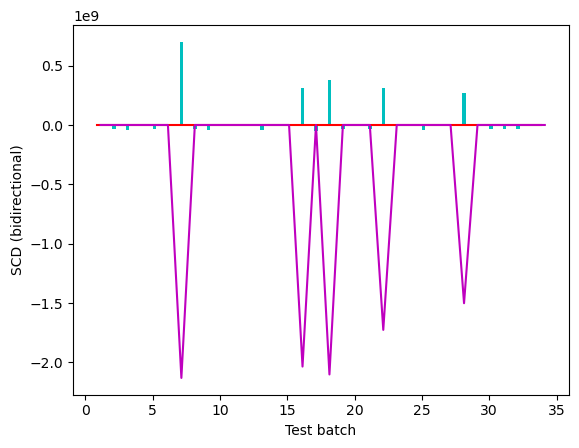

scd_all (bidir) took 71.77482604980469 seconds

 real_world_data/weather_dataset.csv yearly encoder: None

SCD_bidir: [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34] (0.9375, 0.7777777777777778) 

          0         1         2         3         4         5         6  \
0  0.805389  0.840000  0.572727  0.634043  0.142857  0.169851  0.008558   
1  0.820359  0.858537  0.560606  0.651064  0.112782  0.148620  0.009368   
2  0.889222  0.878049  0.492424  0.629787  0.161654  0.191083  0.009657   
3  0.899202  0.926829  0.453030  0.621277  0.210526  0.231423  0.009877   
4  0.941118  0.948293  0.422727  0.629787  0.255639  0.210191  0.010267   

          7  
0  0.785495  
1  0.785495  
2  0.868233  
3  0.877426  
4  0.928498  
t 0 mean: 3.3878 std: 0.0 diff_std: inf time: 1.077026128768921
t 1 mean: 3.31166 std: 0.07614 diff_std: inf time: 2.2529661655426025
t 2 mean: 3.26169 std: 0.09412 diff_std: 0.23612 time: 3.446730375289917


t 24 mean: 28.19564 std: 18.15101 diff_std: 0.01817 time: 0.20883822441101074
t 25 mean: 29.3746 std: 18.74931 diff_std: 0.03296 time: 0.2182750701904297
t 26 mean: 28.50236 std: 18.92875 diff_std: 0.00957 time: 0.2265641689300537
t 27 mean: 28.65083 std: 18.60367 diff_std: 0.01717 time: 0.23593401908874512
t 28 mean: 27.88418 std: 18.72483 diff_std: 0.00651 time: 0.24514532089233398
t 29 mean: 28.46516 std: 18.67405 diff_std: 0.00271 time: 0.2527933120727539
Running in reverse for batch 8
t 0 mean: 3.40463 std: 0.0 diff_std: inf time: 0.0077419281005859375
t 1 mean: 3.36153 std: 0.04309 diff_std: inf time: 0.014850854873657227
t 2 mean: 3.09891 std: 0.37308 diff_std: 7.65775 time: 0.022258758544921875
t 3 mean: 3.18255 std: 0.35409 diff_std: 0.0509 time: 0.030055761337280273
t 4 mean: 3.18426 std: 0.31672 diff_std: 0.10552 time: 0.03782987594604492
t 5 mean: 3.29727 std: 0.38399 diff_std: 0.21239 time: 0.04504871368408203
t 6 mean: 3.32451 std: 0.36172 diff_std: 0.05801 time: 0.052453

t 26 mean: 18.42249 std: 10.72357 diff_std: 0.01869 time: 0.20702099800109863
t 27 mean: 18.20513 std: 10.59073 diff_std: 0.01239 time: 0.2155618667602539
t 28 mean: 18.34103 std: 10.43135 diff_std: 0.01505 time: 0.22318792343139648
t 29 mean: 18.34083 std: 10.25602 diff_std: 0.01681 time: 0.23144006729125977
t 30 mean: 18.19333 std: 10.12154 diff_std: 0.01311 time: 0.2395319938659668
t 31 mean: 18.92566 std: 10.76427 diff_std: 0.0635 time: 0.24711894989013672
t 32 mean: 18.9119 std: 10.60021 diff_std: 0.01524 time: 0.25499701499938965
t 33 mean: 19.22158 std: 10.5936 diff_std: 0.00062 time: 0.2622060775756836
Running in reverse for batch 20
t 0 mean: 7.45845 std: 0.0 diff_std: inf time: 0.008011102676391602
t 1 mean: 6.55286 std: 0.90559 diff_std: inf time: 0.015566825866699219
t 2 mean: 5.61891 std: 1.51369 diff_std: 0.6715 time: 0.023046016693115234
t 3 mean: 6.0682 std: 1.52447 diff_std: 0.00712 time: 0.03143000602722168
t 4 mean: 5.9646 std: 1.37918 diff_std: 0.09531 time: 0.03859

t 25 mean: 16.65207 std: 8.11021 diff_std: 0.0187 time: 0.21210169792175293
t 26 mean: 17.50576 std: 9.07127 diff_std: 0.1185 time: 0.2221057415008545
t 27 mean: 17.17422 std: 9.07287 diff_std: 0.00018 time: 0.2318558692932129
t 28 mean: 17.06319 std: 8.9344 diff_std: 0.01526 time: 0.24081993103027344
t 29 mean: 17.32687 std: 8.89826 diff_std: 0.00405 time: 0.250673770904541
[-177937.60198867274, -137.9430203264542, -20.767777652363748, -245.5757415657622, -132.4863068825366, -292.84406087728985, -21.167034219863126, -40.179624533541755, -13.237187918402014, -177034.34001156842, 74.96549440673016, -262.41399404384265, -120.93888131484209, -174917.3837797391, -406.61586174919876, -171.64462968423413, -165.1341890615231, 83.51362404002748, 85.70146131529646, -191.4362060159474, -22.456569656803822, -168.01824236237735, -4340529.967115126, -8688506.314669002, -197.51537381251455, -195.68074595605913, -321.65561920521895, 35.81599187489837, -234.5348821679304, -109.11450507175459, -33.8106

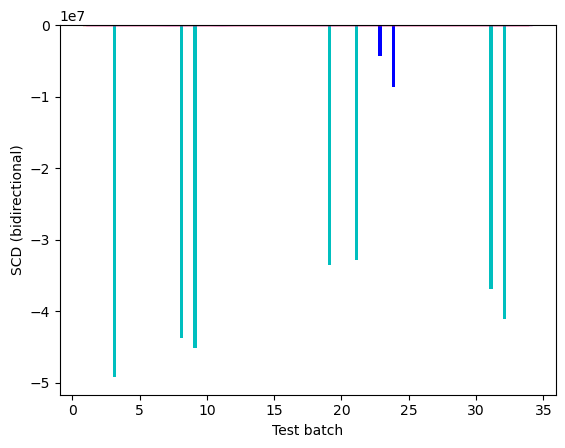

scd_all (bidir) took 64.39061498641968 seconds

 real_world_data/weather_dataset.csv yearly encoder: None

SCD_bidir: [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34] (0.9375, 0.9444444444444444) 



In [10]:
def run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder=None, scaler=None):
    ref_data = X_train
    test_batches = X_test_batches
    ref_labels = y_train
    
#     timer = time()
#     drifts_pca_ref = syncstream_pca_all(ref_data, test_batches, ref_labels, encoder, scaler)
#     print("syncstream_pca_all took", time() - timer, "seconds")
    
#     timer = time()
#     drifts_stat_ref = syncstream_stat_all(ref_data, test_batches, ref_labels, encoder, scaler)
#     print("syncstream_stat_all took", time() - timer, "seconds")
    
#     drifts_scd_unidir = []
#     if encoder != "onehot": # due to matrix errors
#         timer = time()
#         drifts_scd_unidir = scd_all(ref_data, test_batches, ref_labels, encoder, scaler)
#         print("scd_all took", time() - timer, "seconds")

    drifts_scd_bidir = []
    if encoder != "onehot": # due to matrix errors
        timer = time()
        drifts_scd_bidir = scd_all(ref_data, test_batches, ref_labels, encoder, scaler, bidirectional=True)
        print("scd_all (bidir) took", time() - timer, "seconds")

    print("\n", filename, "encoder:", encoder)
    report_1 = [
#         "PCA_ref:",
#         drifts_pca_ref,
#         postprocess_rw(real_drifts, drifts_pca_ref, len(test_batches)),
#         "Stat_ref:",
#         drifts_stat_ref,
#         postprocess_rw(real_drifts, drifts_stat_ref, len(test_batches)),
#         "SCD_unidir:",
#         drifts_scd_unidir,
#         postprocess_rw(real_drifts, drifts_scd_unidir, len(test_batches))
    ]
    report_2 = [
        "SCD_bidir:",
        drifts_scd_bidir,
        postprocess_rw(real_drifts, drifts_scd_bidir, len(test_batches))
    ]

    print(*report_1)
    print(*report_2, "\n")

def run_airlines():
    filename = "real_world_data/airline_dataset.csv"

    data = pd.read_csv(filename)
    df = pd.DataFrame(data)
    train = df.iloc[:179794,:]
    test = df.iloc[179794:,:]
    
    X_train = train.drop(columns=["Delay", "Unnamed: 0"])
    X_test = test.drop(columns=["Delay", "Unnamed: 0"])
    y_train = train[["Delay"]]
    y_test = test[["Delay"]]
    
    X_test_batches = []

    i = 0
    while i < len(X_test):
        new_i = i + 17000
        if new_i > len(X_test):
            new_i = len(X_test)
        X_test_batches.append(X_test[i: new_i])
        i = new_i
        
    # See drift definitions
    real_drifts = [2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22]

    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="onehot", scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="onehot", scaler="minmax")
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="ordinal", scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="ordinal", scaler="minmax")
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="target", scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="target", scaler="minmax")

def run_elect2():
    filename = "real_world_data/electricity_dataset.csv"
    
    data = pd.read_csv(filename)
    df = pd.DataFrame(data)
    
    df["day"] = df["day"].apply(lambda x: float(x.split("\'")[1]))
    
    train = df.iloc[:15104,:]
    test = df.iloc[15104:,:]
    
    X_train = train.drop(columns=["label", "Unnamed: 0", "real_date", "vicprice", "vicdemand"])
    X_test = test.drop(columns=["label", "Unnamed: 0", "real_date", "vicprice", "vicdemand"])
#     X_train = train.drop(columns=["label", "Unnamed: 0", "real_date", "vicprice", "vicdemand", "transfer"])
#     X_test = test.drop(columns=["label", "Unnamed: 0", "real_date", "vicprice", "vicdemand", "transfer"])
    y_train = train[["label"]]
    y_test = test[["label"]]
    
#     mms = MinMaxScaler()
#     X_train = pd.DataFrame(mms.fit_transform(X_train))
#     X_test = pd.DataFrame(mms.transform(X_test))
    
    print(X_train)
    print(np.linalg.matrix_rank(X_train))
    
    X_test_batches = []

    i = 0
    while i < len(X_test):
        new_i = i + 365
        if new_i > len(X_test):
            new_i = len(X_test)
        X_test_batches.append(X_test[i: new_i])
        i = new_i
    
    real_drifts = [1]
    
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder=None, scaler=None)
    
    
def run_weather(monthly):
    filename = "real_world_data/weather_dataset.csv"
    
    data = pd.read_csv(filename)
    df = pd.DataFrame(data)
    
    train = df.iloc[:6053,:]
    test = df.iloc[6053:,:]
    
    X_train = train.drop(columns=["Label_Rain", "Unnamed: 0"])
    X_test = test.drop(columns=["Label_Rain", "Unnamed: 0"])
    
    y_train = train[["Label_Rain"]]
    y_test = test[["Label_Rain"]]
    
    batch_size = 365
    label = filename + " yearly"
    real_drifts = [ 2, 3, 4, 6, 11, 12, 15, 16, 17, 18, 22, 24, 25, 27, 28, 29, 32, 33 ]
    if monthly:
        batch_size = 30
        label = filename + " monthly"
        real_drifts = [11,12,14,18,28,31,35,43,47,48,49,69,92,96,103,108,125,143,145,147,154,162,167,173,174,175,176,177,178,183,185,186,192,197,205,209,210,214,215,217,220,228,246,247,260,265,266,281,283,284,297,302,319,322,323,324,327,335,338,350,353,357,362,383,384,387,389,397,399,400]
        
    X_test_batches = []
    
    i = 0
    while i < len(X_test):
        new_i = i + batch_size
        if new_i > len(X_test):
            new_i = len(X_test)
        X_test_batches.append(X_test[i: new_i])
        i = new_i
        
    run_rw_detectors(X_train, X_test_batches, y_train, label, real_drifts, encoder=None, scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, label, real_drifts, encoder=None, scaler="minmax")
    
    
def run_spam(batch_size):
    filename = "real_world_data/spam_dataset.csv"
    
    data = pd.read_csv(filename)
    df = pd.DataFrame(data).drop(columns=["Unnamed: 0"])
    
    train = df.iloc[:1468,:]
    test = df.iloc[1468:,:]
    
    X_train = train.drop(columns=["ACTUAL_LABEL"])
    X_test = test.drop(columns=["ACTUAL_LABEL"])
    
    print(X_train)
    print(np.linalg.matrix_rank(X_train))
    
    y_train = train[["ACTUAL_LABEL"]]
    y_test = test[["ACTUAL_LABEL"]]
    
    X_test_batches = []
    
    i = 0
    while i < len(X_test):
        new_i = i + batch_size
        if new_i > len(X_test):
            new_i = len(X_test)
        X_test_batches.append(X_test[i: new_i])
        i = new_i
        
    print("batches:", len(X_test_batches))
    
    real_drifts = [1]
    
    label = filename + " " + str(batch_size)
        
    run_rw_detectors(X_train, X_test_batches, y_train, label, real_drifts, encoder=None, scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, label, real_drifts, encoder=None, scaler="minmax")
    
# run_airlines() # try on das6 with SCD
# run_elect2()
# run_weather(monthly=True)
# run_weather(monthly=False)
# run_spam(batch_size=100) # try pca for scd
# run_spam(batch_size=50)
# run_spam(batch_size=20)

In [11]:
# For developing the stat/crit graphs

# deltas = [-500, -112.33805834087934, -5.63757670366158, -254.64638163367908, -105.95361974932212, -277.2522005160049, -0.7797701869503726, -17.160444052856292, 0.6515078028928656, -500, 81.65627519798909, -251.6647424837547, -104.890988106441, -500, -362.3305095837991, -155.8376577058052, -153.27112026764098, 104.28955944645986, 103.35571477773283, -198.54996551748536, -9.33669177511274, -139.4456957732, -500, -500, -164.03845542809495, -203.69279570797062, -309.29205775200353, 30.91586674598011, -221.1829434006777, -71.75523475546379, -0.4561412892317094, 180.17201171699162, -180.71892697522435, -92.823026451837]
# crits = [-112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -44.02884159020756]
# y_label = "SCD (unidirectional)"
# deltas_reverse = [-626.5247613554766, 462.732832569769, 1228.4724605070069, 1428.1028153758189, 1252.3197326216869, -2360.207044655568, -2482.9791209586383]
# crits_reverse = [-1722.3482489631685, -1709.2903407223453, -1790.3885036189583, -1784.6916262708824, -1774.6846479583753, -1828.9015713027097, -1820.821524179729]

# graph(deltas, crits, y_label)


In [12]:
# [ 2, 3, 4, 6, 11, 12, 15, 16, 17, 18, 22, 24, 25, 27, 28, 29, 32, 33 ]